## AlekseevDP(DSU-4,DLL-15)_HW#8_Внимание.

Задание:
- Возьмите англо-русскую пару фраз (https://www.manythings.org/anki/)

- Обучите на них seq2seq with attention:
  - На основе MLP 
  - На основе скалярного произведения
  
- Оцените качество


In [1]:
%matplotlib inline

In [2]:
from io import open
import unicodedata
import string
import re
import random
import math

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import warnings
warnings.simplefilter("ignore", UserWarning)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CUDA_LAUNCH_BLOCKING = "1"
device

device(type='cuda')

In [ ]:
# !wget https://www.manythings.org/anki/rus-eng.zip
# !unzip rus-eng.zip

## Файл https://www.manythings.org/anki/rus-eng.zip потребовал предобработки в программе Anki, а именно - удаления колонки со служебной информацией (номер  карточки перевода, автор и т.п.), иначе при загрузке корпуса возникала ошибка. Предобработанный файл: eng-rus_prepared_full.txt (для быстрого примера см. в репозитории Github файл 'eng-rus_prepared_example.txt')

In [3]:
# переместим предобработанный файл в каталог '/data' и переименуем в 'eng-rus.txt'
!mkdir '/content/data'
# !mv eng-rus_prepared_example.txt '/content/data/eng-rus.txt'
!mv eng-rus_prepared_full.txt '/content/data/eng-rus.txt'

In [4]:
!head -50 data/eng-rus.txt

Go.	Марш!
Hi.	Здравствуйте.
Run!	Беги!
Run.	Беги!
Who?	Кто?
Wow!	Вот это да!
Duck!	Пригнись!
Fire!	Огонь!
Help!	Помогите!
Hide.	Прячься.
Jump!	Прыгай!
Jump.	Прыгай!
Stay.	Оставайся.
Stop!	Стой!
Wait!	Подожди!
Wait.	Ждите.
Do it.	Сделай это.
Go on.	Продолжай.
Hello!	Здравствуйте.
Hurry!	Поспешите.
I ran.	Я бежал.
I see.	Понимаю.
I try.	Я пытаюсь.
I won!	Я победил!
Oh no!	О нет!
Relax.	Расслабьтесь.
Shoot!	Стреляй!
Smile.	Улыбочка.
Sorry?	Извините?
Attack!	В атаку!
Buy it.	Купите её.
Cheers!	За ваше здоровье!
Eat it.	Съешь это.
Eat up.	Доедай.
Freeze!	Ни с места!
Get up.	Вставай.
Go now.	А теперь уходи.
Got it!	Понял!
Got it?	Понял?
He ran.	Он бежал.
Hop in.	Залезай.
Hug me.	Обними меня.
I fell.	Я упал.
I knit.	Я вяжу.
I know.	Я знаю.
I left.	Я ушёл.
I lied.	Я солгал.
I lost.	Я проиграл.
I paid.	Я заплатил.
I pass.	Я пас.


In [5]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

## Через библиотеку Unicodedata не удалось "забороть" кодировку предложений на русском языке, хотя кодировка UTF-8 включает в себя в т.ч. русские буквы (ошибка не возникала, но русскоязычная часть корпуса получалась всегда пустой - 0 фраз). Поэтому нашел альтернативный вариант - русские фразы переводить в транслит с использованием другой библиотеки (Unidecode):

In [6]:
!pip install Unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 28.9 MB/s 


In [7]:
from unidecode import unidecode

In [8]:
def unicodeToAscii(s):
    return ''.join(
        # c for c in unicodedata.normalize('NFD', s)  # Turn a Unicode string to plain ASCII, 
        # if unicodedata.category(c) != 'Mn'          # thanks to http://stackoverflow.com/a/518232/2809427
        c for c in unidecode(s)
)

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [9]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

## На "типовых" префиксах начала предложений (из туториала/лекции) модель Seq2seq показывала хорошую точность предсказаний (лосс ниже 1.0), т.к. корпус был небольшой и предложения короткие. Поэтому с целью эксперимента задача была усложнена: увеличена длина предложения до 100 символов, а также добавлены новые префиксы начала предложений. Итоговый корпус для обучения модели составил 29743 фразы (см.ниже).

In [10]:
MAX_LENGTH = 100

eng_prefixes = (
    "i am", "i m",
    "he is", "he s",
    "she is", "she s",
    "you are", "you re",
    "we are", "we re",
    "they are", "they re",
    "i can", "i can t",
    "that is", "that s",
    "we will", "we ll",
    "i was", "he was", "she was",
    "do you", "are you",
    "i have", "i ve", "i had", "i d",
    "what is", "what s", "what was",
    "what do", "what did",
    "we have", "we ve",
    "i do", "i don t",
    "did", "i ll",
    "there is", "there s",
    "how", "when"
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [11]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'rus', True)
print(random.choice(pairs))

Reading lines...
Read 746410 sentence pairs
Trimmed to 29743 sentence pairs
Counting words...
Counted words:
rus 13446
eng 6084
['u menia est neskol ko dollarov .', 'i have a few dollars .']


In [12]:
print(random.choice(pairs))

['skol ko stoit etot galstuk ?', 'how much does this tie cost ?']


## 1. Реализация 'seq2seq with attention' на основе MLP (Multilayer Perceptron)

The Encoder
-----------





In [13]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

The Decoder
-----------




In [14]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [15]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [16]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [17]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [18]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    # plot_losses = []
    print_loss_total = 0  # Reset every print_every
    # plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        # plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        # if iter % plot_every == 0:
        #     plot_loss_avg = plot_loss_total / plot_every
        #     plot_losses.append(plot_loss_avg)
        #     plot_loss_total = 0

    return 

In [19]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [20]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [21]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 150000, print_every=5000)

1m 24s (- 40m 44s) (5000 3%) 3.7567
2m 41s (- 37m 44s) (10000 6%) 3.2135
4m 2s (- 36m 19s) (15000 10%) 2.9123
5m 20s (- 34m 46s) (20000 13%) 2.7284
6m 40s (- 33m 21s) (25000 16%) 2.5825
7m 59s (- 31m 59s) (30000 20%) 2.4494
9m 22s (- 30m 46s) (35000 23%) 2.3253
10m 41s (- 29m 25s) (40000 26%) 2.2421
12m 1s (- 28m 3s) (45000 30%) 2.1619
13m 23s (- 26m 46s) (50000 33%) 2.1157
14m 43s (- 25m 26s) (55000 36%) 2.0680
16m 3s (- 24m 5s) (60000 40%) 1.9918
17m 25s (- 22m 47s) (65000 43%) 1.9160
18m 45s (- 21m 26s) (70000 46%) 1.8715
20m 5s (- 20m 5s) (75000 50%) 1.7909
21m 27s (- 18m 46s) (80000 53%) 1.7812
22m 47s (- 17m 26s) (85000 56%) 1.7462
24m 7s (- 16m 5s) (90000 60%) 1.7342
25m 29s (- 14m 45s) (95000 63%) 1.7131
26m 49s (- 13m 24s) (100000 66%) 1.6164
28m 9s (- 12m 4s) (105000 70%) 1.6231
29m 30s (- 10m 43s) (110000 73%) 1.6046
30m 49s (- 9m 22s) (115000 76%) 1.5407
32m 8s (- 8m 2s) (120000 80%) 1.5268
33m 28s (- 6m 41s) (125000 83%) 1.5211
34m 47s (- 5m 21s) (130000 86%) 1.5052
36m 6s

In [24]:
evaluateRandomly(encoder1, attn_decoder1)

> podobnaia lest ni k chemu ne privediot .
= that sort of flattery will get you nowhere .
< that seems to make sure . <EOS>

> mne prishlos ostat sia doma .
= i had to stay home .
< i had to stay home . <EOS>

> chto ty sdelal s moimi ochkami ? minutu nazad oni byli zdes .
= what did you do with my glasses ? they were here a minute ago .
< what they they here you were doing with him with him here . <EOS>

> kak dolgo ia spal ?
= how long did i sleep ?
< how long did i sleep ? <EOS>

> kak ty etogo dobilsia ?
= how did you pull that off ?
< how did you get that ? <EOS>

> on krasivyi .
= he is handsome .
< he is handsome . <EOS>

> dumaesh tom pokhudel ?
= do you think tom has lost weight ?
< do you think tom is a ? <EOS>

> ia reshil vypolnit rabotu nezavisimo ot togo kak tiazhelo eto moglo by byt .
= i made up my mind to do the work no matter how hard it might be .
< i made up to buy a job to buy up it it to to to . <EOS>

> chego ty na samom dele khochesh ?
= what do you really want 

## 2. Реализация 'seq2seq with attention' на основе скалярного произведения (Dot Product Attention). Адаптировано с использованием туториала: https://github.com/spro/practical-pytorch/blob/c520c52e68e945d88fff563dba1c028b6ec0197b/seq2seq-translation/seq2seq-translation.ipynb

In [25]:
import unicodedata
import string
import re
import random
import time
import math

import warnings
warnings.simplefilter("ignore", UserWarning)

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

In [26]:
USE_CUDA = torch.cuda.is_available()
USE_CUDA

True

In [27]:
!nvidia-smi

Thu Nov 24 20:19:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    30W /  70W |   1264MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Turning training data into Tensors/Variables

To train we need to turn the sentences into something the neural network can understand, which of course means numbers. Each sentence will be split into words and turned into a Tensor, where each word is replaced with the index (from the Lang indexes made earlier). While creating these tensors we will also append the EOS token to signal that the sentence is over.

![](https://i.imgur.com/LzocpGH.png)

A Tensor is a multi-dimensional array of numbers, defined with some type e.g. FloatTensor or LongTensor. In this case we'll be using LongTensor to represent an array of integer indexes.

Trainable PyTorch modules take Variables as input, rather than plain Tensors. A Variable is basically a Tensor that is able to keep track of the graph state, which is what makes autograd (automatic calculation of backwards gradients) possible.

In [28]:
# Return a list of indexes, one for each word in the sentence
def indexes_from_sentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def variable_from_sentence(lang, sentence):
    indexes = indexes_from_sentence(lang, sentence)
    indexes.append(EOS_token)
    var = Variable(torch.LongTensor(indexes).view(-1, 1))

    if USE_CUDA: var = var.cuda()
    return var

def variables_from_pair(pair):
    input_variable = variable_from_sentence(input_lang, pair[0])
    target_variable = variable_from_sentence(output_lang, pair[1])
    return (input_variable, target_variable)

# Building the models

## The Encoder

The encoder of a seq2seq network is a RNN that outputs some value for every word from the input sentence. For every input word the encoder outputs a vector and a hidden state, and uses the hidden state for the next input word.

In [29]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        
    def forward(self, word_inputs, hidden):
        # Note: we run this all at once (over the whole input sequence)
        seq_len = len(word_inputs)
        embedded = self.embedding(word_inputs).view(seq_len, 1, -1)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def init_hidden(self):
        hidden = Variable(torch.zeros(self.n_layers, 1, self.hidden_size))
        if USE_CUDA: hidden = hidden.cuda()
        return hidden

## Attention Decoder

### Interpreting the Luong et al. model(s)

[Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025) by Luong et al. describe a few more attention models that offer improvements and simplifications. They describe a few "global attention" models, the distinction between them being the way the attention scores are calculated.

The general form of the attention calculation relies on the target (decoder) side hidden state and corresponding source (encoder) side state, normalized over all states to get values summing to 1:

$$
a_t(s) = align(h_t, \bar h_s)  = \dfrac{exp(score(h_t, \bar h_s))}{\sum_{s'} exp(score(h_t, \bar h_{s'}))}
$$

The specific "score" function that compares two states is either *dot*, a simple dot product between the states; *general*, a a dot product between the decoder hidden state and a linear transform of the encoder state; or *concat*, a dot product between a new parameter $v_a$ and a linear transform of the states concatenated together.

$$
score(h_t, \bar h_s) =
\begin{cases}
h_t ^\top \bar h_s & dot \\
h_t ^\top \textbf{W}_a \bar h_s & general \\
v_a ^\top \textbf{W}_a [ h_t ; \bar h_s ] & concat
\end{cases}
$$

The modular definition of these scoring functions gives us an opportunity to build specific attention module that can switch between the different score methods. The input to this module is always the hidden state (of the decoder RNN) and set of encoder outputs.

In [30]:
class Attn(nn.Module):
    def __init__(self, method, hidden_size, max_length=MAX_LENGTH):
        super(Attn, self).__init__()
        
        self.method = method
        self.hidden_size = hidden_size
        
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)

        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.other = nn.Parameter(torch.FloatTensor(1, hidden_size))

    def forward(self, hidden, encoder_outputs):
        seq_len = len(encoder_outputs)

        # Create variable to store attention energies
        attn_energies = Variable(torch.zeros(seq_len)) # B x 1 x S
        if USE_CUDA: attn_energies = attn_energies.cuda()

        # Calculate energies for each encoder output
        for i in range(seq_len):
            attn_energies[i] = self.score(hidden, encoder_outputs[i])

        # Normalize energies to weights in range 0 to 1, resize to 1 x 1 x seq_len
        return F.softmax(attn_energies).unsqueeze(0).unsqueeze(0)
    
    def score(self, hidden, encoder_output):
        
        if self.method == 'dot':
            # energy = hidden.dot(encoder_output)
            energy = hidden@encoder_output.T
            return energy
        
        elif self.method == 'general':
            energy = self.attn(encoder_output)
            # energy = hidden.dot(energy)
            energy = hidden@energy.T
            return energy
        
        elif self.method == 'concat':
            energy = self.attn(torch.cat((hidden, encoder_output), 1))
            # energy = self.other.dot(energy)
            energy = self.other@energy.T
            return energy

Now we can build a decoder that plugs this Attn module in after the RNN to calculate attention weights, and apply those weights to the encoder outputs to get a context vector.

In [31]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, hidden_size, output_size, n_layers=1, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        
        # Keep parameters for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        
        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size * 2, hidden_size, n_layers, dropout=dropout_p)
        self.out = nn.Linear(hidden_size * 2, output_size)
        
        # Choose attention model
        if attn_model != 'none':
            self.attn = Attn(attn_model, hidden_size)
    
    def forward(self, word_input, last_context, last_hidden, encoder_outputs):
        # Note: we run this one step at a time
        
        # Get the embedding of the current input word (last output word)
        word_embedded = self.embedding(word_input).view(1, 1, -1) # S=1 x B x N
        
        # Combine embedded input word and last context, run through RNN
        rnn_input = torch.cat((word_embedded, last_context.unsqueeze(0)), 2)
        rnn_output, hidden = self.gru(rnn_input, last_hidden)

        # Calculate attention from current RNN state and all encoder outputs; apply to encoder outputs
        attn_weights = self.attn(rnn_output.squeeze(0), encoder_outputs)
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1)) # B x 1 x N
        
        # Final output layer (next word prediction) using the RNN hidden state and context vector
        rnn_output = rnn_output.squeeze(0) # S=1 x B x N -> B x N
        context = context.squeeze(1)       # B x S=1 x N -> B x N
        output = F.log_softmax(self.out(torch.cat((rnn_output, context), 1)))
        
        # Return final output, hidden state, and attention weights (for visualization)
        return output, context, hidden, attn_weights

### Testing the models

To make sure the Encoder and Decoder model are working (and working together) we'll do a quick test with fake word inputs

## Для тестирования модели оставим "обычный" dot-product (по условиям задачи) на 1-layer RNN, но остальные способы (general, concat) также работают и могут быть запущены альтернативно

In [41]:
encoder_test = EncoderRNN(10, 10, 1)
decoder_test = AttnDecoderRNN('dot', 10, 10, 1) 
# decoder_test = AttnDecoderRNN('general', 10, 10, 2)
# decoder_test = AttnDecoderRNN('concat', 10, 10, 2)
print(encoder_test)
print(decoder_test)

encoder_hidden = encoder_test.init_hidden()
word_input = Variable(torch.LongTensor([1, 2, 3]))
if USE_CUDA:
    encoder_test.cuda()
    word_input = word_input.cuda()
encoder_outputs, encoder_hidden = encoder_test(word_input, encoder_hidden)

word_inputs = Variable(torch.LongTensor([1, 2, 3]))
decoder_attns = torch.zeros(1, 3, 3)
decoder_hidden = encoder_hidden
decoder_context = Variable(torch.zeros(1, decoder_test.hidden_size))

if USE_CUDA:
    decoder_test.cuda()
    word_inputs = word_inputs.cuda()
    decoder_context = decoder_context.cuda()

for i in range(3):
    decoder_output, decoder_context, decoder_hidden, decoder_attn = decoder_test(word_inputs[i], decoder_context, decoder_hidden, encoder_outputs)
    print(decoder_output.size(), decoder_hidden.size(), decoder_attn.size())
    decoder_attns[0, i] = decoder_attn.squeeze(0).cpu().data

EncoderRNN(
  (embedding): Embedding(10, 10)
  (gru): GRU(10, 10)
)
AttnDecoderRNN(
  (embedding): Embedding(10, 10)
  (gru): GRU(20, 10, dropout=0.1)
  (out): Linear(in_features=20, out_features=10, bias=True)
  (attn): Attn()
)
torch.Size([1, 10]) torch.Size([1, 1, 10]) torch.Size([1, 1, 3])
torch.Size([1, 10]) torch.Size([1, 1, 10]) torch.Size([1, 1, 3])
torch.Size([1, 10]) torch.Size([1, 1, 10]) torch.Size([1, 1, 3])


# Training

## Defining a training iteration

To train we first run the input sentence through the encoder word by word, and keep track of every output and the latest hidden state. Next the decoder is given the last hidden state of the decoder as its first hidden state, and the `<SOS>` token as its first input. From there we iterate to predict a next token from the decoder.

### Teacher Forcing and Scheduled Sampling

"Teacher Forcing", or maximum likelihood sampling, means using the real target outputs as each next input when training. The alternative is using the decoder's own guess as the next input. Using teacher forcing may cause the network to converge faster, but [when the trained network is exploited, it may exhibit instability](http://minds.jacobs-university.de/sites/default/files/uploads/papers/ESNTutorialRev.pdf).

You can observe outputs of teacher-forced networks that read with coherent grammar but wander far from the correct translation - you could think of it as having learned how to listen to the teacher's instructions, without learning how to venture out on its own.

The solution to the teacher-forcing "problem" is known as [Scheduled Sampling](https://arxiv.org/abs/1506.03099), which simply alternates between using the target values and predicted values when training. We will randomly choose to use teacher forcing with an if statement while training - sometimes we'll feed use real target as the input (ignoring the decoder's output), sometimes we'll use the decoder's output.

In [42]:
teacher_forcing_ratio = 0.5
clip = 5.0

def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):

    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0 # Added onto for each word

    # Get size of input and target sentences
    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    # Run words through encoder
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)
    
    # Prepare input and output variables
    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_context = Variable(torch.zeros(1, decoder.hidden_size))
    decoder_hidden = encoder_hidden # Use last hidden state from encoder to start decoder
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        decoder_context = decoder_context.cuda()

    # Choose whether to use teacher forcing
    use_teacher_forcing = random.random() < teacher_forcing_ratio
    if use_teacher_forcing:
        
        # Teacher forcing: Use the ground-truth target as the next input
        for di in range(target_length):
            decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di] # Next target is next input

    else:
        # Without teacher forcing: use network's own prediction as the next input
        for di in range(target_length):
            decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_variable[di])
            
            # Get most likely word index (highest value) from output
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]
            
            decoder_input = Variable(torch.LongTensor([[ni]])) # Chosen word is next input
            if USE_CUDA: decoder_input = decoder_input.cuda()

            # Stop at end of sentence (not necessary when using known targets)
            if ni == EOS_token: break

    # Backpropagation
    loss.backward()
    torch.nn.utils.clip_grad_norm(encoder.parameters(), clip)
    torch.nn.utils.clip_grad_norm(decoder.parameters(), clip)
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    # return loss.data[0] / target_length
    return loss.item() / target_length

Finally helper functions to print time elapsed and estimated time remaining, given the current time and progress.

In [43]:
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

## Running training

With everything in place we can actually initialize a network and start training.

To start, we initialize models, optimizers, and a loss function (criterion).

## Для реализации Attention'a оставим "обычный" dot-product (по условиям задачи)на 1-слойной RNN, но остальные способы (general, concat) также работают и могут быть запущены альтернативно

In [45]:
attn_model = 'dot'
# attn_model = 'general'
# attn_model = 'concat'
hidden_size = 256
n_layers = 1
dropout_p = 0.1

# Initialize models
encoder = EncoderRNN(input_lang.n_words, hidden_size, n_layers)
decoder = AttnDecoderRNN(attn_model, hidden_size, output_lang.n_words, n_layers, dropout_p=dropout_p)

# Move models to GPU
if USE_CUDA:
    encoder.cuda()
    decoder.cuda()

# Initialize optimizers and criterion
learning_rate = 0.01
encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

Then set up variables for plotting and tracking progress:

In [46]:
# Configuring training
n_epochs = 150000
plot_every = 200
print_every = 5000

# Keep track of time elapsed and running averages
start = time.time()
plot_losses = []
print_loss_total = 0 # Reset every print_every
plot_loss_total = 0 # Reset every plot_every

To actually train, we call the train function many times, printing a summary as we go.

*Note:* If you run this notebook you can train, interrupt the kernel, evaluate, and continue training later. You can comment out the lines above where the encoder and decoder are initialized (so they aren't reset) or simply run the notebook starting from the following cell.

In [47]:
# Begin!
for epoch in range(1, n_epochs + 1):
    
    # Get training data for this cycle
    training_pair = variables_from_pair(random.choice(pairs))
    input_variable = training_pair[0]
    target_variable = training_pair[1]

    # Run the train function
    loss = train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)

    # Keep track of loss
    print_loss_total += loss
    plot_loss_total += loss

    if epoch == 0: continue

    if epoch % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print_summary = '%s (%d %d%%) %.4f' % (time_since(start, epoch / n_epochs), epoch, epoch / n_epochs * 100, print_loss_avg)
        print(print_summary)

    if epoch % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0

1m 50s (- 53m 35s) (5000 3%) 3.8429
3m 35s (- 50m 14s) (10000 6%) 3.5375
5m 23s (- 48m 31s) (15000 10%) 3.3571
7m 12s (- 46m 48s) (20000 13%) 3.2059
9m 3s (- 45m 17s) (25000 16%) 3.0601
10m 52s (- 43m 30s) (30000 20%) 2.9869
12m 42s (- 41m 46s) (35000 23%) 2.8659
14m 31s (- 39m 56s) (40000 26%) 2.8056
16m 21s (- 38m 11s) (45000 30%) 2.7461
18m 10s (- 36m 21s) (50000 33%) 2.6509
20m 1s (- 34m 35s) (55000 36%) 2.6273
21m 50s (- 32m 46s) (60000 40%) 2.5452
23m 41s (- 30m 59s) (65000 43%) 2.5135
25m 30s (- 29m 9s) (70000 46%) 2.4555
27m 21s (- 27m 21s) (75000 50%) 2.4157
29m 10s (- 25m 31s) (80000 53%) 2.3764
31m 0s (- 23m 42s) (85000 56%) 2.2978
32m 51s (- 21m 54s) (90000 60%) 2.2754
34m 41s (- 20m 5s) (95000 63%) 2.2426
36m 33s (- 18m 16s) (100000 66%) 2.2429
38m 24s (- 16m 27s) (105000 70%) 2.1531
40m 18s (- 14m 39s) (110000 73%) 2.1666
42m 9s (- 12m 49s) (115000 76%) 2.1300
44m 2s (- 11m 0s) (120000 80%) 2.1091
45m 53s (- 9m 10s) (125000 83%) 2.0428
47m 45s (- 7m 20s) (130000 86%) 2.02

## Plotting training loss

Plotting is done with matplotlib, using the array `plot_losses` that was created while training.

<Figure size 432x288 with 0 Axes>

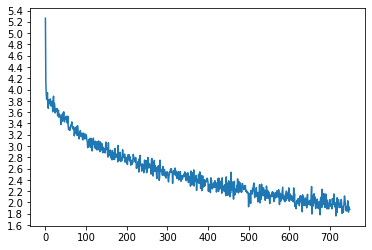

In [48]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # put ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

show_plot(plot_losses)

# Evaluating the network

Evaluation is mostly the same as training, but there are no targets. Instead we always feed the decoder's predictions back to itself. Every time it predicts a word, we add it to the output string. If it predicts the EOS token we stop there. We also store the decoder's attention outputs for each step to display later.

In [49]:
def evaluate(sentence, max_length=MAX_LENGTH):
    input_variable = variable_from_sentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    
    # Run through encoder
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)

    # Create starting vectors for decoder
    decoder_input = Variable(torch.LongTensor([[SOS_token]])) # SOS
    decoder_context = Variable(torch.zeros(1, decoder.hidden_size))
    if USE_CUDA:
        decoder_input = decoder_input.cuda()
        decoder_context = decoder_context.cuda()

    decoder_hidden = encoder_hidden
    
    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)
    
    # Run through decoder
    for di in range(max_length):
        decoder_output, decoder_context, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_context, decoder_hidden, encoder_outputs)
        decoder_attentions[di,:decoder_attention.size(2)] += decoder_attention.squeeze(0).squeeze(0).cpu().data

        # Choose top word from output
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            # decoded_words.append(output_lang.index2word[ni])
            decoded_words.append(output_lang.index2word[topi.item()])
            
        # Next input is chosen word
        decoder_input = Variable(torch.LongTensor([[ni]]))
        if USE_CUDA: decoder_input = decoder_input.cuda()
    
    return decoded_words, decoder_attentions[:di+1, :len(encoder_outputs)]

We can evaluate random sentences from the training set and print out the input, target, and output to make some subjective quality judgements:

In [50]:
def evaluate_randomly(n=10):
    for i in range(n):
      pair = random.choice(pairs)
    
      output_words, decoder_attn = evaluate(pair[0])
      output_sentence = ' '.join(output_words)
    
      print('>', pair[0])
      print('=', pair[1])
      print('<', output_sentence)
      print('')

In [52]:
evaluate_randomly()

> chto ty delal proshloi noch iu ?
= what did you do last night ?
< what did you do last night ? <EOS>

> vam nravitsia vasha novaia rabota ?
= are you pleased with your new job ?
< do you like your new job ? <EOS>

> ia byl nemnogo emotsionalen .
= i was a bit emotional .
< i was a bit a bit . <EOS>

> ia byl v depressii .
= i was depressed .
< i was at . <EOS>

> ona vsegda kurit .
= she is always smoking .
< she is always . . <EOS>

> u menia chetyre tuza .
= i have four aces .
< i have a . . <EOS>

> kak by ia eto sdelal ?
= how would i do that ?
< how did i do that ? <EOS>

> ty sobiraesh sia srubit vse eti derev ia ?
= are you going to cut down all these trees ?
< are you going to get the the the ? ? ? <EOS>

> u menia net prichin otkazyvat sia ot moego plana .
= there is no reason that i should give up my plan .
< i have no no idea to the the the . . <EOS>

> mne nado napisat pis mo . u tebia est bumaga ?
= i have to write a letter . do you have some paper ?
< what have i have t

# Visualizing attention

A useful property of the attention mechanism is its highly interpretable outputs. Because it is used to weight specific encoder outputs of the input sequence, we can imagine looking where the network is focused most at each time step.

You could simply run `plt.matshow(attentions)` to see attention output displayed as a matrix, with the columns being input steps and rows being output steps:

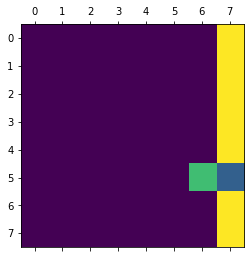

In [53]:
output_words, attentions = evaluate("chto ty delal proshloi noch iu ?")
plt.matshow(attentions.numpy())

For a better viewing experience we will do the extra work of adding axes and labels:

In [54]:
def show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [55]:
def evaluateAndShowAttention(input_sentence_):
    output_words, attentions = evaluate(input_sentence_)
    print('input =', input_sentence_)
    print('output =', ' '.join(output_words))
    show_attention(input_sentence_, output_words, attentions)

input = chto ty delal proshloi noch iu ?
output = what did you do last night ? <EOS>


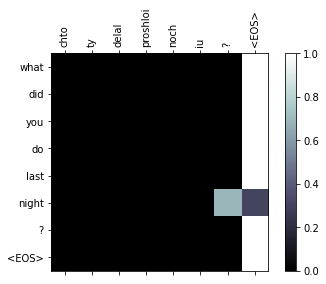

In [56]:
evaluateAndShowAttention("chto ty delal proshloi noch iu ?")

input = u menia net prichin otkazyvat sia ot moego plana .
output = i have no no idea to the the the . . <EOS>


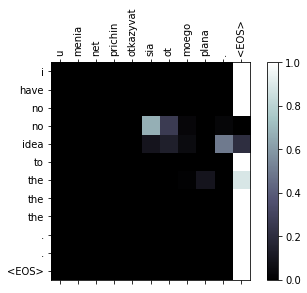

In [58]:
evaluateAndShowAttention("u menia net prichin otkazyvat sia ot moego plana .")

## Общий вывод по сравнению вариантов - MLP отработал качественнее (быстрее и с меньшим лоссом), визуально качество перевода также было выше у MLP:
## 1. Multilayer Perceptron: 40m 2s (150000 100%) 1.4061
## 2. Dot-product Attention @1-layer RNN: 55m 9s (150000 100%) 1.9266

## Возможно, более высокого качества модели seq2seq на Dot-Product Attention удалось бы добиться с увеличением количества слоев в RNN (>=2) или с использованием других способов обработки скрытого состояния ('general' или 'concat').